In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import sparse

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Importar los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# --- 1. Carga de Datos ---
BASE_P4 = Path.cwd().parent / "4_ponderacion"
BASE_P3 = Path.cwd().parent / "3_caracteristicas_bow"
BASE_P2_PREPROC = Path.cwd().parent / "2_preprocesamiento"

# Cargar etiquetas 'y' desde el archivo que originó las matrices para garantizar alineación
df_corpus = pd.read_csv(BASE_P2_PREPROC / "2_corpus_preprocesado.csv")
y = df_corpus['label'].values

# --- CARGA DE LAS 8 MATRICES PRE-PROCESADAS ---
# Cargar las 4 matrices de conteo (TO) desde el Punto 3
X_TO_none = sparse.load_npz(BASE_P3 / "matrices" / "bow_raw.npz")
X_TO_stopwords = sparse.load_npz(BASE_P3 / "matrices" / "bow_stopwords.npz")
X_TO_stem_only = sparse.load_npz(BASE_P3 / "matrices" / "bow_stem_only.npz")
X_TO_both = sparse.load_npz(BASE_P3 / "matrices" / "bow_stemmed_stopwords.npz")

# Cargar las 4 matrices TF-IDF (generadas y guardadas en Punto 4)
X_TFIDF_none = sparse.load_npz(BASE_P4 / "artifacts_p4" / "X_TFIDF_none.npz")
X_TFIDF_stopwords = sparse.load_npz(BASE_P4 / "artifacts_p4" / "X_TFIDF_stopwords_only.npz")
X_TFIDF_stem_only = sparse.load_npz(BASE_P4 / "artifacts_p4" / "X_TFIDF_stemming_only.npz")
X_TFIDF_both = sparse.load_npz(BASE_P4 / "artifacts_p4" / "X_TFIDF_both_stop+stem.npz")

print("✅ Las 8 matrices (4 TO y 4 TF-IDF) se han cargado correctamente.")

# --- 2. División de Datos (Train/Test) ---
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    np.arange(len(y)), y, test_size=0.20, random_state=42, stratify=y
)

# --- 3. Definición de los Experimentos ---
# Diccionario con las 8 configuraciones, apuntando a las matrices ya cargadas
feature_sets = {
    # Ponderación TO
    "1_TO_no_stop_no_stem": X_TO_none,
    "2_TO_stop_no_stem": X_TO_stopwords,
    "3_TO_no_stop_stem": X_TO_stem_only,
    "4_TO_stop_stem": X_TO_both,
    # Ponderación TF-IDF
    "5_TFIDF_no_stop_no_stem": X_TFIDF_none,
    "6_TFIDF_stop_no_stem": X_TFIDF_stopwords,
    "7_TFIDF_no_stop_stem": X_TFIDF_stem_only,
    "8_TFIDF_stop_stem": X_TFIDF_both,
}

# --- 4. Entrenamiento y Evaluación ---
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Árboles de Decisión": DecisionTreeClassifier(random_state=42),
    "K Vecinos más Cercanos": KNeighborsClassifier(n_neighbors=5),
    "Máquina de Vectores de Soporte": SVC(random_state=42)
}

results = []
print("\n🚀 Iniciando experimentos (8 configuraciones)...")

for config_name, X in feature_sets.items():
    print(f"   Procesando: {config_name}")
    X_train, X_test = X[X_train_idx], X[X_test_idx]

    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_weighted')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        pond = "TFIDF" if "TFIDF" in config_name else "TO"
        stopwords_active = "no_stop" not in config_name
        stemming_active = "no_stem" not in config_name
        
        results.append({
            "MODELO": model_name, "POND": pond,
            "STOPWORDS": "TRUE" if stopwords_active else "FALSE",
            "STEMMING": "TRUE" if stemming_active else "FALSE",
            "PRECISION": precision, "RECALL": recall, "F1-SCORE": f1,
            "CV_F1_MEAN": np.mean(cv_scores)
        })

print("\n✅ Experimentos finalizados.")

# --- 5. Presentación de Resultados ---
df_results = pd.DataFrame(results)
df_results['#'] = df_results.groupby(['POND', 'STOPWORDS', 'STEMMING']).ngroup() + 1
pivot_table = df_results.pivot_table(
    index=["#", "POND", "STOPWORDS", "STEMMING"],
    columns="MODELO",
    values=["PRECISION", "RECALL", "F1-SCORE"]
)
pivot_table = pivot_table.reorder_levels(axis=1, order=["MODELO", None])
pivot_table = pivot_table.sort_index(axis=1, level="MODELO", sort_remaining=False)
pivot_table = pivot_table.sort_index(level='#')
pd.set_option('display.max_columns', None)

print("\n--- Tabla de Resultados Completos ---")
try:
    display(pivot_table.style.format("{:.4f}").background_gradient(cmap='viridis', axis=None))
except NameError:
    print(pivot_table.round(4))

✅ Las 8 matrices (4 TO y 4 TF-IDF) se han cargado correctamente.

🚀 Iniciando experimentos (8 configuraciones)...
   Procesando: 1_TO_no_stop_no_stem
   Procesando: 2_TO_stop_no_stem
   Procesando: 3_TO_no_stop_stem
   Procesando: 4_TO_stop_stem
   Procesando: 5_TFIDF_no_stop_no_stem
   Procesando: 6_TFIDF_stop_no_stem
   Procesando: 7_TFIDF_no_stop_stem
   Procesando: 8_TFIDF_stop_stem

✅ Experimentos finalizados.

--- Tabla de Resultados Completos ---


C:\Users\juana\AppData\Local\Temp\ipykernel_18372\478215687.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=max_f1.index, y=max_f1.values, palette='plasma')


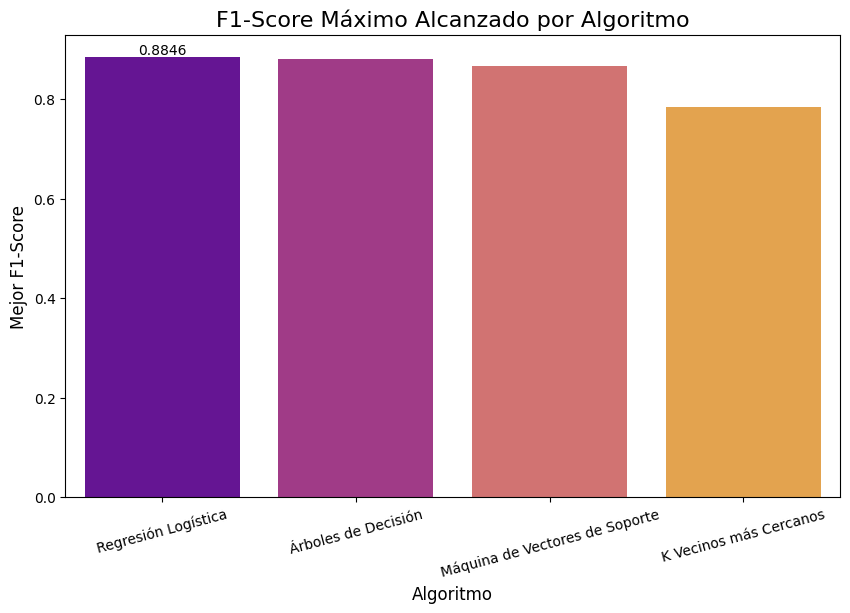

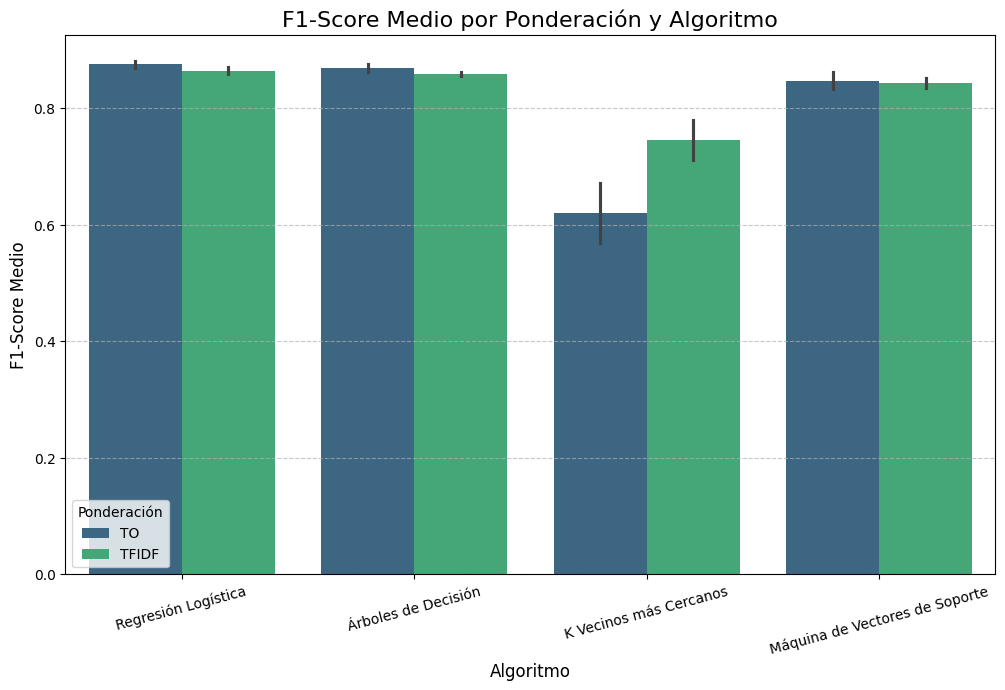

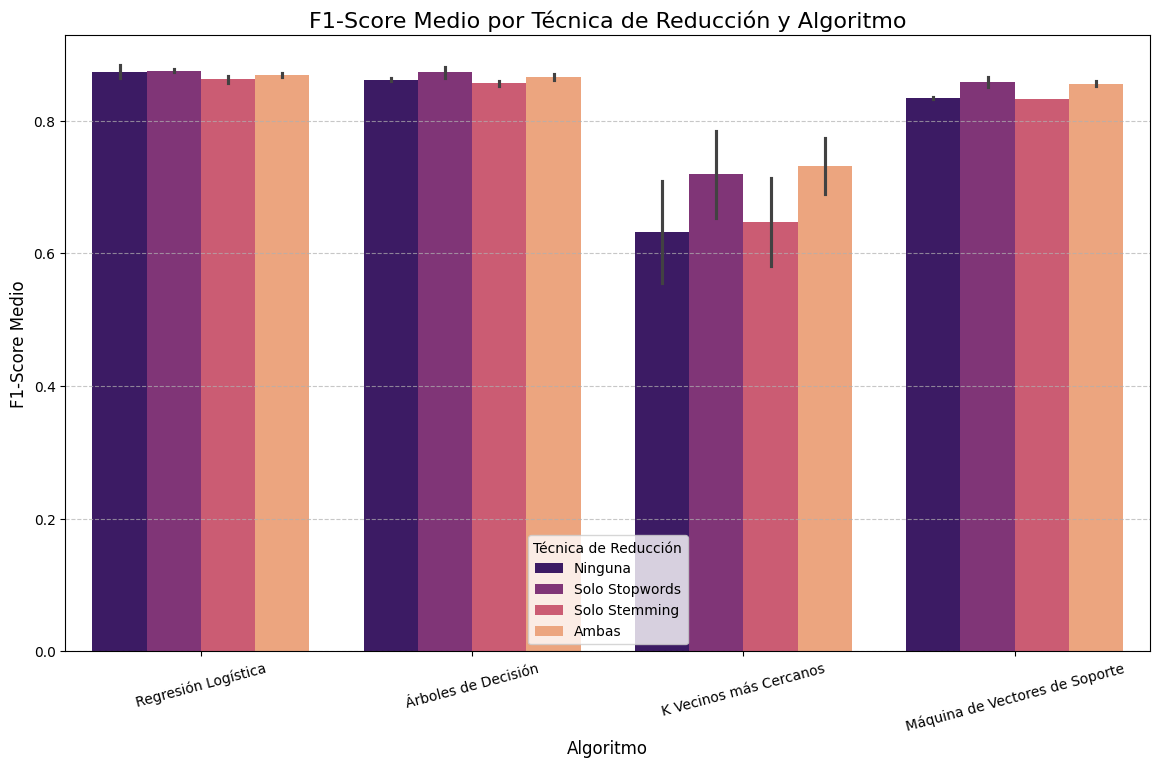

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_tecnica(row):
    if row['STOPWORDS'] == 'TRUE' and row['STEMMING'] == 'TRUE':
        return 'Ambas'
    elif row['STOPWORDS'] == 'TRUE':
        return 'Solo Stopwords'
    elif row['STEMMING'] == 'TRUE':
        return 'Solo Stemming'
    else:
        return 'Ninguna'

df_results['TECNICA'] = df_results.apply(get_tecnica, axis=1)


# --- Gráfica 1: F1-Score Máximo por Algoritmo ---
max_f1 = df_results.groupby('MODELO')['F1-SCORE'].max().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=max_f1.index, y=max_f1.values, palette='plasma')
ax.bar_label(ax.containers[0], fmt='%.4f')
plt.title('F1-Score Máximo Alcanzado por Algoritmo', fontsize=16)
plt.ylabel('Mejor F1-Score', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.xticks(rotation=15)
plt.show()


# --- Gráfica 2: F1-Score Medio por Ponderación y Algoritmo ---
plt.figure(figsize=(12, 7))
sns.barplot(data=df_results, x='MODELO', y='F1-SCORE', hue='POND', palette='viridis')
plt.title('F1-Score Medio por Ponderación y Algoritmo', fontsize=16)
plt.ylabel('F1-Score Medio', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Ponderación')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- Gráfica 3: F1-Score Medio por Técnica de Reducción y Algoritmo ---
plt.figure(figsize=(14, 8))
sns.barplot(data=df_results, x='MODELO', y='F1-SCORE', hue='TECNICA', 
            hue_order=['Ninguna', 'Solo Stopwords', 'Solo Stemming', 'Ambas'], palette='magma')
plt.title('F1-Score Medio por Técnica de Reducción y Algoritmo', fontsize=16)
plt.ylabel('F1-Score Medio', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Técnica de Reducción')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Revisar